In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt

from scipy.stats import mode

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def plot_classifier(clf, X, y, X_test=None, y_test=None, title=None, target_names = None):
    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    step = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    
    xx, yy = np.meshgrid(np.arange(x_min-k, x_max+k, step), 
                         np.arange(y_min-k, y_max+k, step))

    P = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    P = P.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, P, cmap=cmap_light, alpha = 0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, 
                s=plot_symbol_size, edgecolor = 'black')
    plt.xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    plt.ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, 
                    s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        plt.legend(loc=0, handles=legend_handles)

    if (title is not None):
        plt.title(title)
    plt.show()

# Load Mushrooms Data

<IPython.core.display.Javascript object>


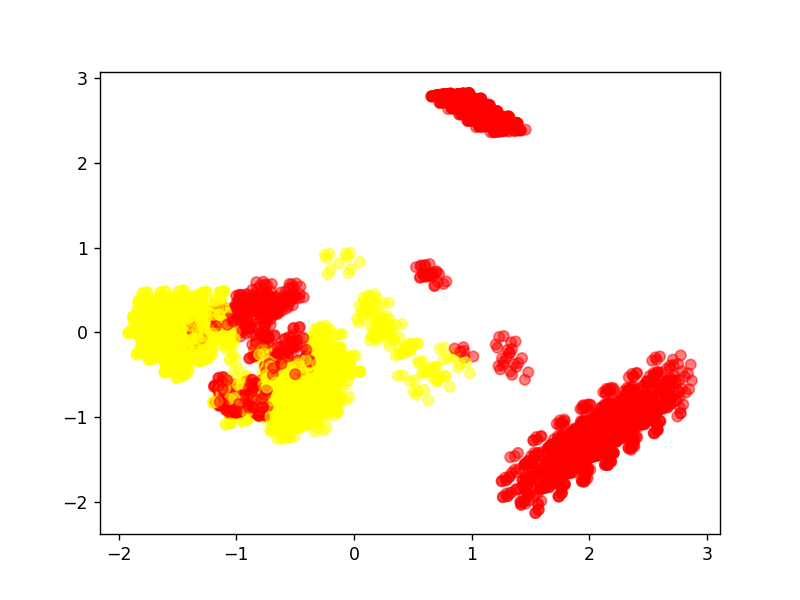

In [3]:
mushrooms = pd.read_csv("datasets/mushrooms.csv")
data = pd.get_dummies(mushrooms)

data["edible"] = data["class_e"]
data.drop(["class_e", "class_p"], axis=1, inplace=True)
target_names=["Poisoned", "Edible"]

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# pca for 2d
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# train test set
X_train, X_test, y_train, y_test = train_test_split(X_2d, y, random_state=0)

# vis
plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="autumn", marker="o", alpha=0.5)

0.8788774002954209


<IPython.core.display.Javascript object>


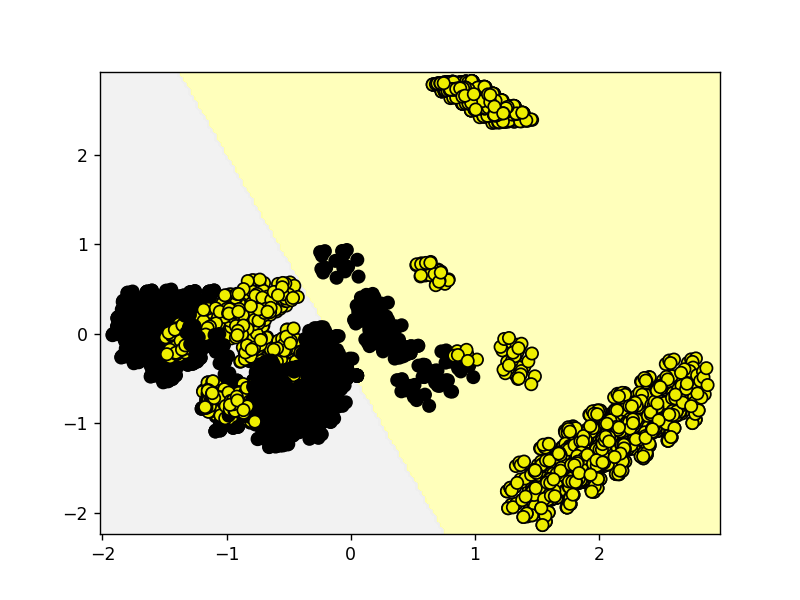

In [182]:
# logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train, y_train)
print(lr.score(X_test, y_test))
plot_classifier(lr, X_2d, y)

# Decision Tree Classifier

In [21]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=4, min_samples_size=5):
        self.max_depth = max_depth
        self.min_samples_size = min_samples_size
    
    def fit(self, X_train, y_train):
        self.root = self.get_best_split(X_train, y_train)
        self.split(self.root, 1)
        return self
    
    def gini_index(self, label_groups, class_set):
        # count all samples
        n_samples = sum([len(group) for group in label_groups])
        # calculate gini index
        gini = 0.0
        for group in label_groups:
            size = len(group)
            # pass divide by 0
            if size == 0:
                continue
            
            score = 0.0
            # score for each class
            for class_name in class_set:
                p = list(group).count(class_name) / size
                score += p ** 2
            
            # weighted sum for gini index
            gini += (size / n_samples) * (1 - score)
    
        return gini
    
    def split_by_value(self, index, value, X, y):
        left_indexes = X[:, index] >= value
        right_indexes = X[:, index] < value
        # create splitted data
        X_left = X[left_indexes, :]
        X_right = X[right_indexes, :]
        y_left = y[left_indexes]
        y_right = y[right_indexes]
        
        return X_left, X_right, y_left, y_right
    
    def get_best_split(self, X, y):
        class_set = list(set(y))
        best_index, best_value, best_gini = float("inf"), float("inf"), float("inf")
        best_X_groups, best_y_groups = None, None
        # loop in features
        for index in range(X.shape[1]):
            # find feature values to split the data on each of them
            value_set = list(set(X[:, index]))
            value_set = value_set[::len(value_set)//20+1]
            # loop in values of this feature
            for value in value_set:
                X_left, X_right, y_left, y_right = self.split_by_value(index, value, X, y)
                gini = self.gini_index([y_left, y_right], class_set)
                # update best values
                if gini < best_gini:
                    best_index = index
                    best_value = value
                    best_gini = gini
                    best_X_groups = [X_left, X_right]
                    best_y_groups = [y_left, y_right]
            
        return {"index": best_index, "value": best_value, 
                "X_groups": best_X_groups, "y_groups": best_y_groups}
    
    def split(self, node, depth):
        """splits a node recursively"""
        X_left, X_right = node["X_groups"]
        y_left, y_right = node["y_groups"]
        del(node["X_groups"])
        del(node["y_groups"])
        
        # check for a no split
        if not X_left.size or not X_right.size:
            output_labels = np.concatenate((y_left.ravel(), y_right.ravel()))
            node["left"] = node["right"] = mode(output_labels)[0][0]
            return
    
        # check for max depth
        if depth >= self.max_depth:
            node["left"] = mode(y_left)[0][0]
            node["right"] = mode(y_right)[0][0]
            return
        
        # process left child
        if len(y_left) <= self.min_samples_size:
            node["left"] = mode(y_left)[0][0]
        else:
            node["left"] = self.get_best_split(X_left, y_left)
            self.split(node["left"], depth+1)
        
        # process right child
        if len(y_right) <= self.min_samples_size:
            node["right"] = mode(y_right)[0][0]
        else:
            node["right"] = self.get_best_split(X_right, y_right)
            self.split(node["right"], depth+1)
    
    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            prediction = self._predict(self.root, X[i])
            predictions.append(prediction)
        return np.array(predictions)
        
    def _predict(self, node, row):
        if row[node["index"]] >= node["value"]:
            if isinstance(node["left"], dict):
                return self._predict(node["left"], row)
            else:
                return node["left"]
        
        else:
            if isinstance(node["right"], dict):
                return self._predict(node["right"], row)
            else:
                return node["right"]
    
    def score(self, X, y):
        preds = self.predict(X)
        return (y == preds).mean()
    
    def print_tree(self, node, depth=0):
        if isinstance(node, dict):
            print(" "*depth + "X" + str(node["index"]) + " >= " + str(node["value"])[:4])
            self.print_tree(node["left"], depth+1)
            self.print_tree(node["right"], depth+1)
        else:
            print(" "*depth + str(node))

In [22]:
dt = DecisionTreeClassifier(max_depth=7, min_samples_size=10).fit(X_train, y_train)

In [23]:
dt.score(X_train, y_train)

0.9499425570326604

In [24]:
dt.score(X_test, y_test)

0.9453471196454948

<IPython.core.display.Javascript object>


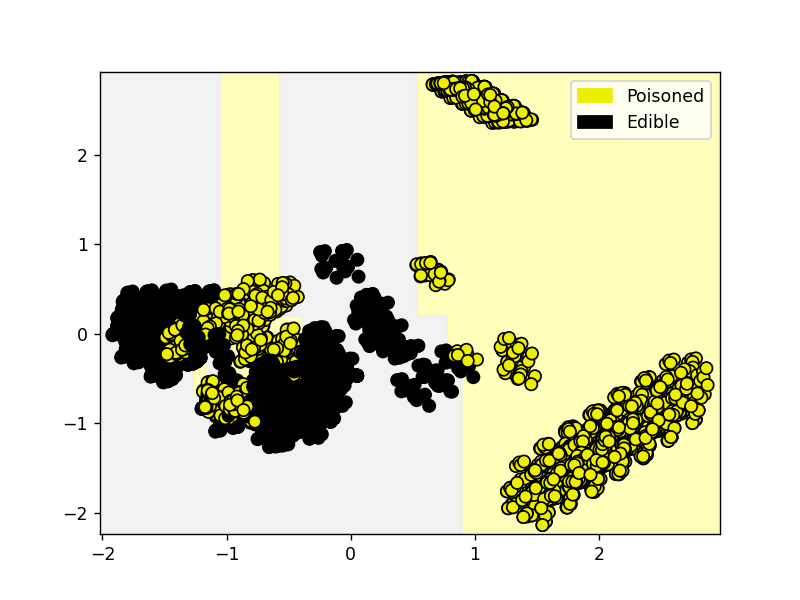

In [25]:
plot_classifier(dt, X_2d, y, target_names=target_names)

In [26]:
dt.print_tree(dt.root, 0)

X0 >= 0.78
 X0 >= 0.89
  X0 >= 0.90
   X0 >= 1.05
    X0 >= 1.37
     X0 >= 1.37
      0
      0
     X0 >= 1.06
      X0 >= 1.06
       0
       0
      X0 >= 1.06
       0
       0
    X1 >= -0.2
     X0 >= 0.93
      X0 >= 0.93
       0
       0
      X0 >= 0.92
       0
       0
     0
   0
  X1 >= -0.2
   X1 >= 2.64
    X0 >= 0.87
     X0 >= 0.87
      0
      0
     X0 >= 0.85
      X0 >= 0.85
       0
       0
      X0 >= 0.80
       0
       0
    0
   1
 X0 >= -1.2
  X1 >= 0.21
   X0 >= -1.1
    X0 >= -1.0
     X0 >= -0.5
      X0 >= 0.52
       0
       1
      X0 >= -0.8
       0
       0
     X0 >= -1.0
      0
      X1 >= 0.29
       1
       1
    X1 >= 0.28
     X0 >= -1.1
      1
      X0 >= -1.1
       1
       1
     1
   X0 >= -0.6
    X1 >= -0.4
     X0 >= -0.4
      X0 >= -0.3
       1
       1
      X1 >= -0.3
       0
       1
     X1 >= -0.5
      X0 >= -0.4
       1
       1
      X1 >= -0.6
       1
       1
    X0 >= -1.1
     X1 >= -0.6
      X0 >= -0.9
    

In [27]:
dt.get_best_split(X_train, y_train)

{'index': 0,
 'value': 0.7855957807185815,
 'X_groups': [array([[ 0.87182241,  2.7418603 ],
         [ 1.19515294,  2.52059629],
         [ 2.37563269, -0.52090357],
         ...,
         [ 1.55685435, -1.84408413],
         [ 1.99095188, -1.28616355],
         [ 0.9694451 ,  2.72791003]]),
  array([[-1.30799532,  0.11703769],
         [-0.21855903, -0.65913237],
         [-1.54666261,  0.25818687],
         ...,
         [-0.44905159, -0.75069412],
         [-1.49095929, -0.09378244],
         [-1.57780417,  0.31452444]])],
 'y_groups': [array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
  array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)]}

# Random Forest

In [30]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=4, min_samples_size=5, n_features=None):
        self.max_depth = max_depth
        self.min_samples_size = min_samples_size
        self.n_features = n_features
    
    def fit(self, X_train, y_train):
        self.root = self.get_best_split(X_train, y_train)
        self.split(self.root, 1)
        return self
    
    def gini_index(self, label_groups, class_set):
        # count all samples
        n_samples = sum([len(group) for group in label_groups])
        # calculate gini index
        gini = 0.0
        for group in label_groups:
            size = len(group)
            # pass divide by 0
            if size == 0:
                continue
            
            score = 0.0
            # score for each class
            for class_name in class_set:
                p = list(group).count(class_name) / size
                score += p ** 2
            
            # weighted sum for gini index
            gini += (size / n_samples) * (1 - score)
    
        return gini
    
    def split_by_value(self, index, value, X, y):
        left_indexes = X[:, index] >= value
        right_indexes = X[:, index] < value
        # create splitted data
        X_left = X[left_indexes, :]
        X_right = X[right_indexes, :]
        y_left = y[left_indexes]
        y_right = y[right_indexes]
        
        return X_left, X_right, y_left, y_right
    
    def get_best_split(self, X, y):
        class_set = list(set(y))
        best_index, best_value, best_gini = float("inf"), float("inf"), float("inf")
        best_X_groups, best_y_groups = None, None
        
        # random features
        random_features = np.random.choice(X.shape[1], self.n_features, replace=False)
        
        # loop in features
        for index in random_features:
            # find feature values to split the data on each of them
            value_set = list(set(X[:, index]))
            value_set = value_set[::len(value_set)//20+1]
            # loop in values of this feature
            for value in value_set:
                X_left, X_right, y_left, y_right = self.split_by_value(index, value, X, y)
                gini = self.gini_index([y_left, y_right], class_set)
                # update best values
                if gini < best_gini:
                    best_index = index
                    best_value = value
                    best_gini = gini
                    best_X_groups = [X_left, X_right]
                    best_y_groups = [y_left, y_right]
            
        return {"index": best_index, "value": best_value, 
                "X_groups": best_X_groups, "y_groups": best_y_groups}
    
    def split(self, node, depth):
        """splits a node recursively"""
        X_left, X_right = node["X_groups"]
        y_left, y_right = node["y_groups"]
        del(node["X_groups"])
        del(node["y_groups"])
        
        # check for a no split
        if not X_left.size or not X_right.size:
            output_labels = np.concatenate((y_left.ravel(), y_right.ravel()))
            node["left"] = node["right"] = mode(output_labels)[0][0]
            return
    
        # check for max depth
        if depth >= self.max_depth:
            node["left"] = mode(y_left)[0][0]
            node["right"] = mode(y_right)[0][0]
            return
        
        # process left child
        if len(y_left) <= self.min_samples_size:
            node["left"] = mode(y_left)[0][0]
        else:
            node["left"] = self.get_best_split(X_left, y_left)
            self.split(node["left"], depth+1)
        
        # process right child
        if len(y_right) <= self.min_samples_size:
            node["right"] = mode(y_right)[0][0]
        else:
            node["right"] = self.get_best_split(X_right, y_right)
            self.split(node["right"], depth+1)
    
    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            prediction = self._predict(self.root, X[i])
            predictions.append(prediction)
        return np.array(predictions)
        
    def _predict(self, node, row):
        if row[node["index"]] >= node["value"]:
            if isinstance(node["left"], dict):
                return self._predict(node["left"], row)
            else:
                return node["left"]
        
        else:
            if isinstance(node["right"], dict):
                return self._predict(node["right"], row)
            else:
                return node["right"]
    
    def score(self, X, y):
        preds = self.predict(X)
        return (y == preds).mean()
    
    def print_tree(self, node, depth=0):
        if isinstance(node, dict):
            print(" "*depth + "X" + str(node["index"]) + " >= " + str(node["value"])[:4])
            self.print_tree(node["left"], depth+1)
            self.print_tree(node["right"], depth+1)
        else:
            print(" "*depth + str(node))

In [59]:
class RandomForestClassifier:
    def __init__(self, n_estimators=50, max_depth=4, min_samples_size=7, n_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_size = min_samples_size
        self.n_features = n_features
    
    def fit(self, X_train, y_train):
        if not self.n_features:
            self.n_features = int(np.sqrt(X_train.shape[1]))
        # fit random trees
        self.trees = []
        for i in range(self.n_estimators):
            # get random samples
            X_sample, y_sample = self.random_sample(X_train, y_train, ratio=0.2)
            # fit a tree
            tree = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_size=self.min_samples_size,
                                         n_features=self.n_features).fit(X_sample, y_sample)
            self.trees.append(tree)
        
        return self
    
    def random_sample(self, X, y, ratio=0.2):
        n_sample = int(len(y) * ratio)
        random_indices = np.random.choice(len(y), n_sample)
        X_sample = X[random_indices, :]
        y_sample = y[random_indices]
        return X_sample, y_sample
    
    def predict(self, X):
        predictions = []
        for row in X:
            votes = [tree.predict(np.array([row]))[0] for tree in self.trees]
            prediction = mode(votes)[0][0]
            predictions.append(prediction)
        return np.array(predictions)
    
    def score(self, X, y):
        predictions = self.predict(X)
        return (y == predictions).mean()

In [89]:
rf = RandomForestClassifier(n_estimators=30, max_depth=7, min_samples_size=5, n_features=2).fit(X_train, y_train)

In [90]:
rf.score(X_train, y_train)

0.9555227310027901

In [91]:
rf.score(X_test, y_test)

0.9566715903495815

In [92]:
rf.trees[0].score(X_train, y_train)

0.9358279993435089

<IPython.core.display.Javascript object>


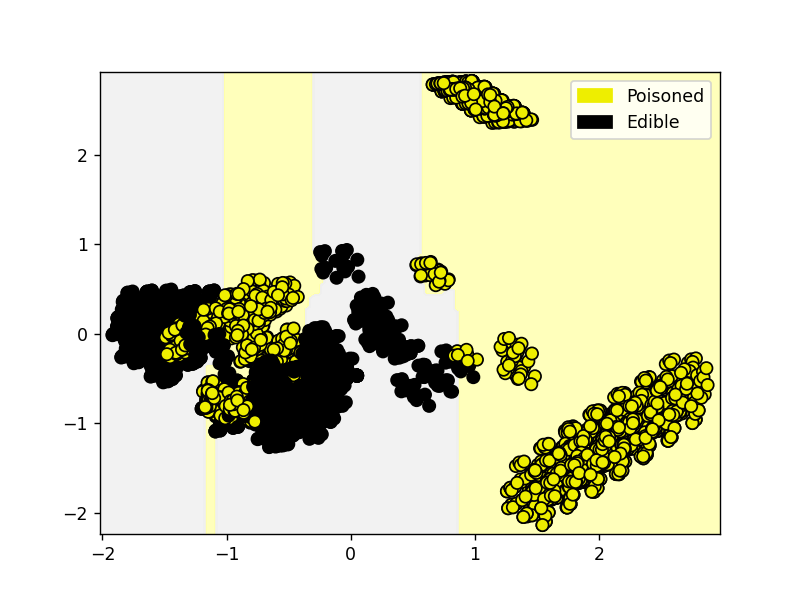

In [93]:
plot_classifier(rf, X_2d, y, target_names=target_names)

# XGBoost Classifier

In [94]:
from xgboost import XGBClassifier

In [178]:
xgb = XGBClassifier(n_estimators=500, max_depth=4).fit(X_train, y_train)

[01:32:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [185]:
xgb.score(X_train, y_train)

1.0

In [186]:
xgb.score(X_test, y_test)

0.967011324470704

<IPython.core.display.Javascript object>


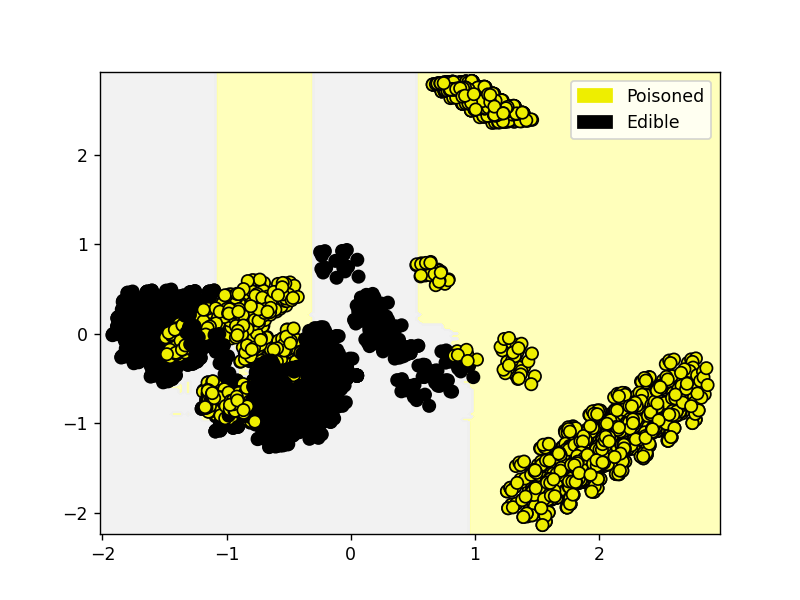

In [187]:
plot_classifier(xgb, X_2d, y, target_names=target_names)